In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

from pysim import SimRegressor, SimClassifier

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y > 0] = 1
y[y <= 0] = 0
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

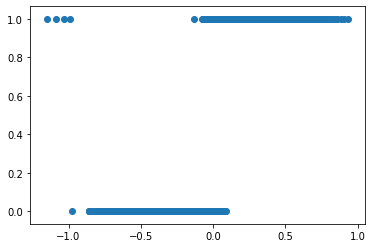

In [3]:
plt.scatter(np.dot(x, beta), y)

## ASpline Classifier

In [4]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   20.5s remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   25.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.1s finished


CPU times: user 5.57 s, sys: 13.7 s, total: 19.3 s
Wall time: 26.5 s


In [ ]:
roc_auc_score(test_y, grid.predict_proba(test_x))

0.9944297270566258

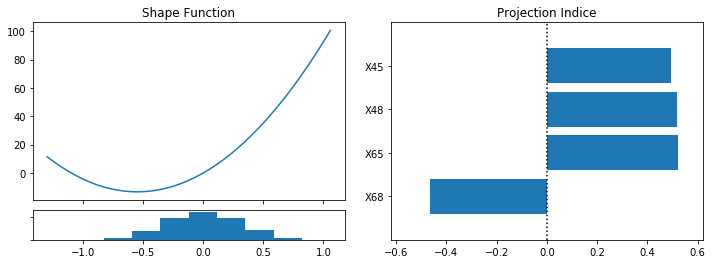

In [ ]:
grid.best_estimator_.visualize()

## LogitBoost

In [ ]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0),
                    scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)},
                    param_grid=param_grid, n_jobs=-1, refit="mse", verbose=2, error_score=np.nan)
grid.fit(train_x, train_y * 4 - 2)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:    7.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   14.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.1s finished


CPU times: user 3.04 s, sys: 7.64 s, total: 10.7 s
Wall time: 15.3 s


In [ ]:
roc_auc_score(test_y, 1 / (1 + np.exp(- grid.predict(test_x))))

0.9931326635005115

In [ ]:
grid.best_estimator_.visualize()